In [ ]:
%pip install tensorflow
%pip install scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

In [ ]:
#Run this command to access data from google drive in CoLab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Make a shortcut from the "Shared with me" to your "My Drive" folder
%cd '/content/drive/My Drive/BreastLesionML'

/content/drive/.shortcut-targets-by-id/1lOR3gtDD2SuGv4J_Et_c-7b7Vi7eTfdc/BreastLesionML


In [ ]:
# Kevin's path
%cd '/content/drive/MyDrive/BME 548 Final Project/BreastLesionML'

/content/drive/.shortcut-targets-by-id/1lOR3gtDD2SuGv4J_Et_c-7b7Vi7eTfdc/BreastLesionML


In [ ]:
# check gpu
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [ ]:
training_array_RAW = np.load('training_array_RAW.npy')
training_array_LOW_CONTRAST = np.load('training_array_LOW_CONTRAST.npy')
training_array_LOW_RES = np.load('training_array_LOW_RES.npy')
training_array_COMBINED = np.load('training_array_COMBINED.npy')
training_labels_array = np.load('training_labels_array.npy')

validation_array_RAW = np.load('validation_array_RAW.npy')
validation_array_LOW_CONTRAST = np.load('validation_array_LOW_CONTRAST.npy')
validation_array_LOW_RES = np.load('validation_array_LOW_RES.npy')
validation_array_COMBINED = np.load('validation_array_COMBINED.npy')
validation_labels_array = np.load('validation_labels_array.npy')

test_array_RAW = np.load('test_array_RAW.npy')
test_array_LOW_CONTRAST = np.load('test_array_LOW_CONTRAST.npy')
test_array_LOW_RES = np.load('test_array_LOW_RES.npy')
test_array_COMBINED = np.load('test_array_COMBINED.npy')
test_labels_array = np.load('test_labels_array.npy')

In [ ]:
rid = 1500
indices_to_remove = np.where(training_labels_array == 0)[0][:rid]

# Remove the corresponding elements from both arrays A and B
training_array_RAW = np.delete(training_array_RAW, indices_to_remove, axis=0)
training_array_LOW_CONTRAST = np.delete(training_array_LOW_CONTRAST, indices_to_remove, axis=0)
training_array_LOW_RES = np.delete(training_array_LOW_RES, indices_to_remove, axis=0)
training_array_COMBINED = np.delete(training_array_COMBINED, indices_to_remove, axis=0)
training_labels_array = np.delete(training_labels_array, indices_to_remove)

# Model 1 functions

In [ ]:
def compile(model, class_weights):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=weighted_sparse_categorical_crossentropy(class_weights),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def fit(model, training_array, training_labels, validation_array, validation_labels):
  return model.fit(training_array_RAW, training_labels_array,
              epochs=50,
              batch_size=32,
              validation_data=(validation_array_RAW, validation_labels_array))

In [ ]:
def metrics(model, test_array, test_labels):
    data = np.zeros((3, 3))
    normal = np.where(test_labels == 0)[0]
    for i in normal:
      sample = test_array[i, :, :]
      sample = np.reshape(sample, (1, 225, 225, 1))
      output = np.argmax(model.predict(sample))
      if output == 0:
        data[0][0] += 1
      elif output == 1:
        data[0][1] += 1
      else:
        data[0][2] += 1

    benign = np.where(test_labels == 1)[0]
    for i in benign:
      sample = test_array[i, :, :]
      sample = np.reshape(sample, (1, 225, 225, 1))
      output = np.argmax(model.predict(sample))
      if output == 0:
        data[1][0] += 1
      elif output == 1:
        data[1][1] += 1
      else:
        data[1][2] += 1

    cancer = np.where(test_labels == 2)[0]
    for i in cancer:
      sample = test_array[i, :, :]
      sample = np.reshape(sample, (1, 225, 225, 1))
      output = np.argmax(model.predict(sample))
      if output == 0:
        data[2][0] += 1
      elif output == 1:
        data[2][1] += 1
      else:
        data[2][2] += 1

    return data

In [ ]:
# custom loss function

def weighted_sparse_categorical_crossentropy(class_weights):
    """
    Custom loss function: Weighted Sparse Categorical Crossentropy

    Parameters:
    - class_weights: Dictionary of class weights. Keys are class indices, and values are corresponding weights.
    """
    class_weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)

    def loss(y_true, y_pred):
        # Compute standard sparse categorical cross-entropy loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

        # Apply class weights
        weighted_loss = loss * tf.gather(class_weights_tensor, tf.cast(y_true, dtype=tf.int32))

        # Compute mean loss
        return tf.reduce_mean(weighted_loss)

    return loss

## Model 1, RAW

In [ ]:
# adapted from https://ieeexplore.ieee.org/abstract/document/744052
def original_model():
  input_shape = (225, 225, 1)
  model = tf.keras.models.Sequential([
      # Input layer
      tf.keras.layers.InputLayer(input_shape=input_shape),
      # convolution 1:
      tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
      # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
      # max pooling layer 1:
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      # convolution 2:
      tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
      # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
      # max pooling layer 2:
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      # convolution 3:
      tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
      # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
      # max pooling layer 3:
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      # dense layer:
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=3, activation='softmax')
  ])
  return model

In [ ]:
class_weights_original = {0: 1.0, 1: 10.0, 2: 200.0}

model_original_RAW = original_model()
model_original_RAW = compile(model_original_RAW, class_weights_original)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [ ]:
hist_original_RAW = fit(model_original_RAW,
                        training_array_RAW,
                        training_labels_array,
                        validation_array_RAW,
                        validation_labels_array)

Epoch 1/50
53/53 [==============================] - 8s 49ms/step - loss: 5.9943 - accuracy: 0.8744 - val_loss: 24.9385 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 24ms/step - loss: 5.9106 - accuracy: 0.8875 - val_loss: 27.2433 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 24ms/step - loss: 5.5751 - accuracy: 0.8875 - val_loss: 27.9445 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 24ms/step - loss: 5.0736 - accuracy: 0.8869 - val_loss: 33.7977 - val_accuracy: 0.8059
Epoch 5/50
53/53 [==============================] - 1s 24ms/step - loss: 4.6819 - accuracy: 0.8887 - val_loss: 18.6259 - val_accuracy: 0.8140
Epoch 6/50
53/53 [==============================] - 1s 24ms/step - loss: 4.7490 - accuracy: 0.8887 - val_loss: 25.2382 - val_accuracy: 0.8356
Epoch 7/50
53/53 [==============================] - 1s 24ms/step - loss: 3.8235 - accuracy: 0.8940 - val_loss: 28.1565 - val_accuracy: 0.8356
Epoch 

In [ ]:
data_original_RAW = metrics(model_original_RAW, test_array_RAW, test_labels_array)
norm = np.sum(data_original_RAW, axis=1)
data_original_RAW = np.transpose(data_original_RAW / norm[:, np.newaxis])

1/1 [==============================] - 0s 19ms/step


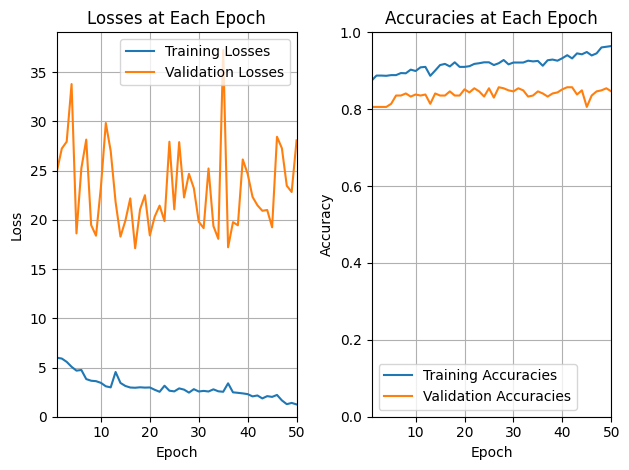

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_original_RAW.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_original_RAW.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_original_RAW.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_original_RAW.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

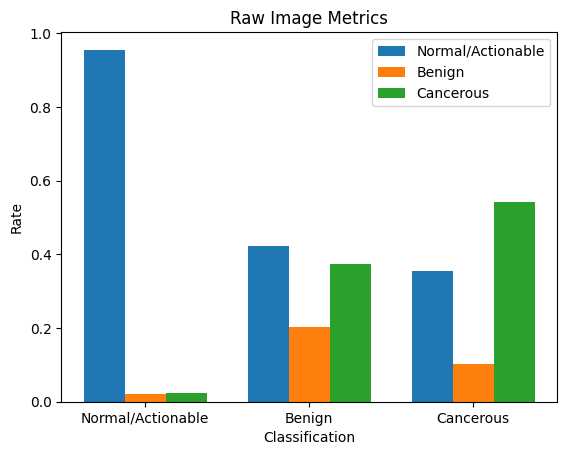

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_original_RAW[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_original_RAW[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_original_RAW[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Raw Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 1, LOW_RES

In [ ]:
model_original_LOW_RES = original_model()
model_original_LOW_RES = compile(model_original_LOW_RES, class_weights_original)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 32)       

In [ ]:
hist_original_LOW_RES = fit(model_original_LOW_RES,
                        training_array_LOW_RES,
                        training_labels_array,
                        validation_array_LOW_RES,
                        validation_labels_array)

Epoch 1/50
53/53 [==============================] - 3s 31ms/step - loss: 5.9210 - accuracy: 0.8726 - val_loss: 27.0286 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 25ms/step - loss: 5.0795 - accuracy: 0.8875 - val_loss: 32.7741 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 25ms/step - loss: 4.8176 - accuracy: 0.8875 - val_loss: 55.9593 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 24ms/step - loss: 4.6480 - accuracy: 0.8887 - val_loss: 19.9699 - val_accuracy: 0.8167
Epoch 5/50
53/53 [==============================] - 1s 25ms/step - loss: 4.3585 - accuracy: 0.8851 - val_loss: 25.1388 - val_accuracy: 0.8005
Epoch 6/50
53/53 [==============================] - 1s 25ms/step - loss: 4.1900 - accuracy: 0.8827 - val_loss: 28.3833 - val_accuracy: 0.8005
Epoch 7/50
53/53 [==============================] - 1s 25ms/step - loss: 3.8640 - accuracy: 0.8940 - val_loss: 20.0026 - val_accuracy: 0.8329
Epoch 

In [ ]:
data_original_LOW_RES = metrics(model_original_LOW_RES, test_array_LOW_RES, test_labels_array)
norm = np.sum(data_original_LOW_RES, axis=1)
data_original_LOW_RES = np.transpose(data_original_LOW_RES / norm[:, np.newaxis])

1/1 [==============================] - 0s 21ms/step


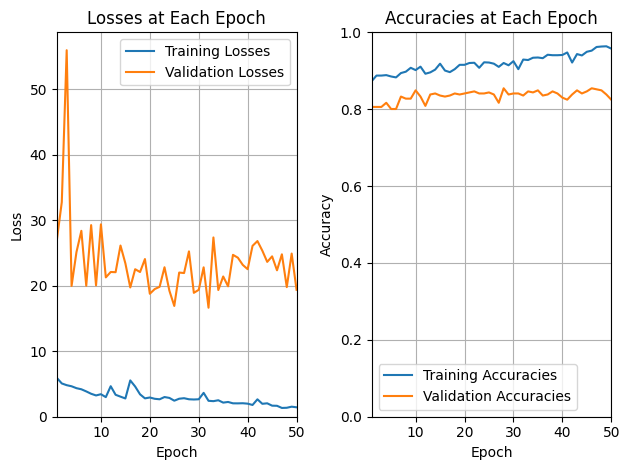

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_original_LOW_RES.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_original_LOW_RES.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_original_LOW_RES.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_original_LOW_RES.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

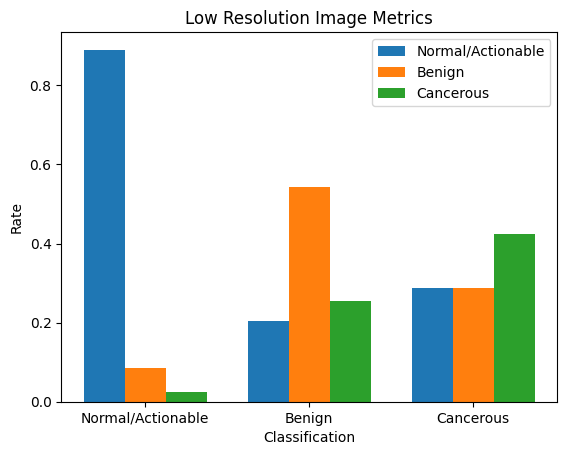

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_original_LOW_RES[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_original_LOW_RES[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_original_LOW_RES[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Low Resolution Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 1, LOW_CONTRAST

In [ ]:
model_original_LOW_CONTRAST = original_model()
model_original_LOW_CONTRAST = compile(model_original_LOW_CONTRAST, class_weights_original)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 32)       

In [ ]:
hist_original_LOW_CONTRAST = fit(model_original_LOW_CONTRAST,
                        training_array_LOW_CONTRAST,
                        training_labels_array,
                        validation_array_LOW_CONTRAST,
                        validation_labels_array)

Epoch 1/50
53/53 [==============================] - 3s 30ms/step - loss: 5.3255 - accuracy: 0.8732 - val_loss: 31.1719 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 25ms/step - loss: 5.2556 - accuracy: 0.8875 - val_loss: 37.7745 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 25ms/step - loss: 4.7959 - accuracy: 0.8875 - val_loss: 28.2106 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 24ms/step - loss: 4.7407 - accuracy: 0.8952 - val_loss: 32.5041 - val_accuracy: 0.8005
Epoch 5/50
53/53 [==============================] - 1s 25ms/step - loss: 4.6819 - accuracy: 0.8958 - val_loss: 35.2862 - val_accuracy: 0.8032
Epoch 6/50
53/53 [==============================] - 1s 25ms/step - loss: 3.4007 - accuracy: 0.9060 - val_loss: 23.6070 - val_accuracy: 0.8410
Epoch 7/50
53/53 [==============================] - 1s 25ms/step - loss: 3.7446 - accuracy: 0.8946 - val_loss: 19.3130 - val_accuracy: 0.8140
Epoch 

In [ ]:
data_original_LOW_CONTRAST = metrics(model_original_LOW_CONTRAST, test_array_LOW_CONTRAST, test_labels_array)
norm = np.sum(data_original_LOW_CONTRAST, axis=1)
data_original_LOW_CONTRAST = np.transpose(data_original_LOW_CONTRAST/norm[:, np.newaxis])

1/1 [==============================] - 0s 19ms/step


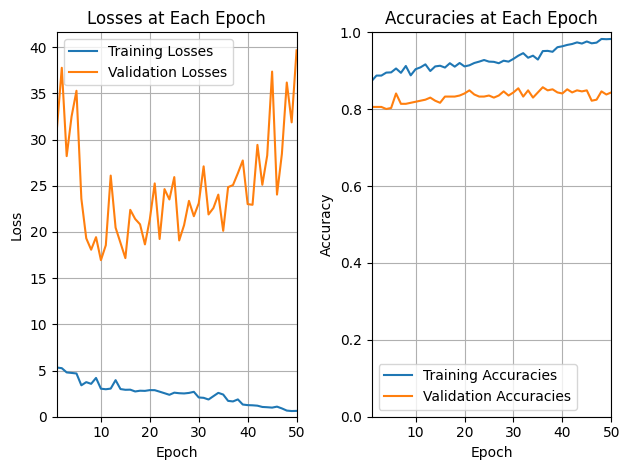

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_original_LOW_CONTRAST.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_original_LOW_CONTRAST.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_original_LOW_CONTRAST.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_original_LOW_CONTRAST.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

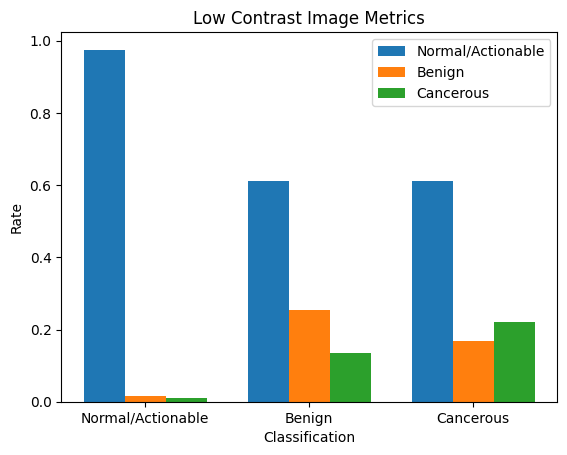

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_original_LOW_CONTRAST[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_original_LOW_CONTRAST[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_original_LOW_CONTRAST[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Low Contrast Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 1, COMBINED

In [ ]:
model_original_COMBINED = original_model()
model_original_COMBINED = compile(model_original_COMBINED, class_weights_original)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 32)        25632     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 28, 28, 32)       

In [ ]:
hist_original_COMBINED = fit(model_original_COMBINED,
                        training_array_COMBINED,
                        training_labels_array,
                        validation_array_COMBINED,
                        validation_labels_array)

Epoch 1/50
53/53 [==============================] - 3s 30ms/step - loss: 5.7813 - accuracy: 0.8708 - val_loss: 28.6757 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 25ms/step - loss: 4.9486 - accuracy: 0.8875 - val_loss: 26.9125 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 25ms/step - loss: 5.0902 - accuracy: 0.8881 - val_loss: 25.7014 - val_accuracy: 0.8032
Epoch 4/50
53/53 [==============================] - 1s 25ms/step - loss: 3.9994 - accuracy: 0.8964 - val_loss: 41.1405 - val_accuracy: 0.8086
Epoch 5/50
53/53 [==============================] - 1s 25ms/step - loss: 4.8222 - accuracy: 0.8946 - val_loss: 22.9187 - val_accuracy: 0.8194
Epoch 6/50
53/53 [==============================] - 1s 25ms/step - loss: 3.4874 - accuracy: 0.9054 - val_loss: 17.2044 - val_accuracy: 0.8194
Epoch 7/50
53/53 [==============================] - 1s 24ms/step - loss: 4.0586 - accuracy: 0.8970 - val_loss: 22.9426 - val_accuracy: 0.8140
Epoch 

In [ ]:
data_original_COMBINED = metrics(model_original_COMBINED, test_array_COMBINED, test_labels_array)
norm = np.sum(data_original_COMBINED, axis=1)
data_original_COMBINED = np.transpose(data_original_COMBINED / norm[:, np.newaxis])

1/1 [==============================] - 0s 19ms/step


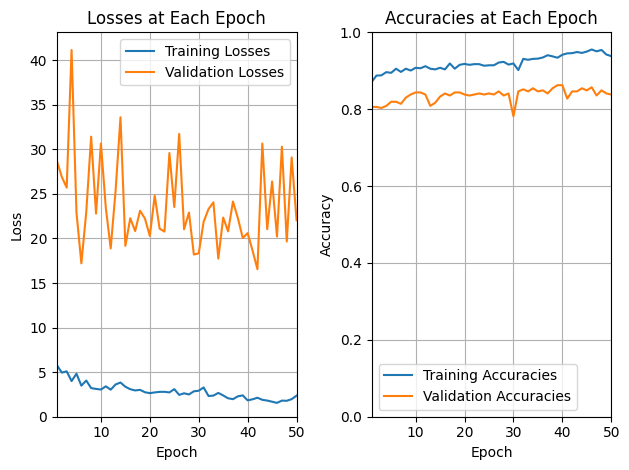

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_original_COMBINED.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_original_COMBINED.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_original_COMBINED.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_original_COMBINED.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

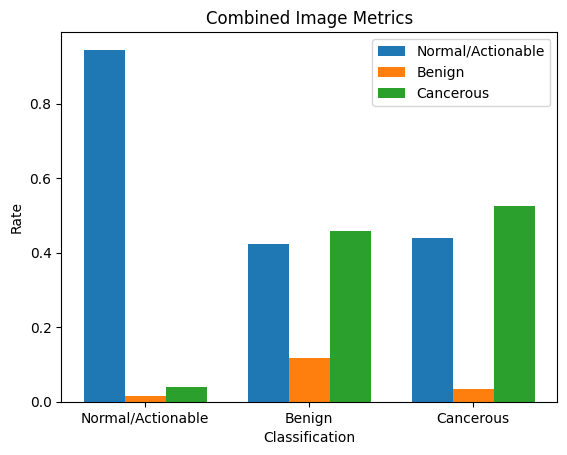

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_original_COMBINED[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_original_COMBINED[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_original_COMBINED[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Combined Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 2, RAW

In [ ]:
# removed a conv layer from the original model to account for potential overfitting
def simple_cnn_model():
    input_shape = (225, 225, 1)
    model = tf.keras.models.Sequential([
        # Input layer
        tf.keras.layers.InputLayer(input_shape=input_shape),
        # convolution 1:
        tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
        # max pooling layer 1:
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        # convolution 2:
        tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
        # max pooling layer 2:
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        # dense layer:
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=3, activation='softmax')
    ])
    return model

In [ ]:
class_weights_simple_cnn = {0: 1.0, 1: 10.0, 2: 200.0}

model_simple_cnn_RAW = simple_cnn_model()
model_simple_cnn_RAW = compile(model_simple_cnn_RAW, class_weights_simple_cnn)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 3)                

In [ ]:
hist_simple_cnn_RAW = fit(model_simple_cnn_RAW,
                          training_array_RAW,
                          training_labels_array,
                          validation_array_RAW,
                          validation_labels_array)

Epoch 1/50
53/53 [==============================] - 3s 29ms/step - loss: 5.8005 - accuracy: 0.8720 - val_loss: 31.3850 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 23ms/step - loss: 4.9318 - accuracy: 0.8875 - val_loss: 25.7103 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 23ms/step - loss: 4.8667 - accuracy: 0.8899 - val_loss: 19.0230 - val_accuracy: 0.8329
Epoch 4/50
53/53 [==============================] - 1s 23ms/step - loss: 4.7246 - accuracy: 0.8839 - val_loss: 25.7879 - val_accuracy: 0.8032
Epoch 5/50
53/53 [==============================] - 1s 23ms/step - loss: 3.6736 - accuracy: 0.9036 - val_loss: 19.7849 - val_accuracy: 0.8356
Epoch 6/50
53/53 [==============================] - 1s 23ms/step - loss: 3.9986 - accuracy: 0.8923 - val_loss: 25.2006 - val_accuracy: 0.8005
Epoch 7/50
53/53 [==============================] - 1s 24ms/step - loss: 3.7021 - accuracy: 0.8964 - val_loss: 17.6902 - val_accuracy: 0.8437
Epoch 

In [ ]:
data_simple_cnn_RAW = metrics(model_simple_cnn_RAW, test_array_RAW, test_labels_array)
norm = np.sum(data_simple_cnn_RAW, axis=1)
data_simple_cnn_RAW = np.transpose(data_simple_cnn_RAW / norm[:, np.newaxis])

1/1 [==============================] - 0s 21ms/step


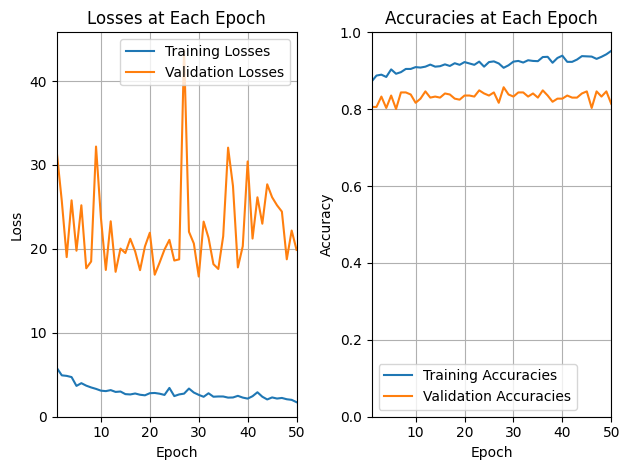

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_simple_cnn_RAW.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_simple_cnn_RAW.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_simple_cnn_RAW.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_simple_cnn_RAW.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

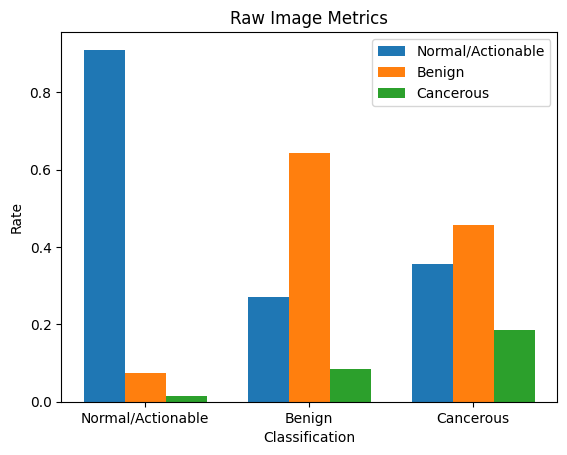

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_simple_cnn_RAW[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_simple_cnn_RAW[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_simple_cnn_RAW[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Raw Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 2, LOW_RES

In [ ]:
model_simple_cnn_LOW_RES = simple_cnn_model()
model_simple_cnn_LOW_RES = compile(model_simple_cnn_LOW_RES, class_weights_simple_cnn)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [ ]:
hist_simple_cnn_LOW_RES = fit(model_simple_cnn_LOW_RES,
                          training_array_LOW_RES,
                          training_labels_array,
                          validation_array_LOW_RES,
                          validation_labels_array)

Epoch 1/50
53/53 [==============================] - 1s 26ms/step - loss: 1.7823 - accuracy: 0.9452 - val_loss: 25.8575 - val_accuracy: 0.8437
Epoch 2/50
53/53 [==============================] - 1s 23ms/step - loss: 1.6968 - accuracy: 0.9548 - val_loss: 22.4322 - val_accuracy: 0.8275
Epoch 3/50
53/53 [==============================] - 1s 23ms/step - loss: 1.5688 - accuracy: 0.9518 - val_loss: 22.6298 - val_accuracy: 0.8329
Epoch 4/50
53/53 [==============================] - 1s 23ms/step - loss: 1.6091 - accuracy: 0.9571 - val_loss: 19.7627 - val_accuracy: 0.8275
Epoch 5/50
53/53 [==============================] - 1s 23ms/step - loss: 1.8539 - accuracy: 0.9423 - val_loss: 21.7182 - val_accuracy: 0.8221
Epoch 6/50
53/53 [==============================] - 1s 23ms/step - loss: 1.4633 - accuracy: 0.9506 - val_loss: 22.8884 - val_accuracy: 0.8275
Epoch 7/50
53/53 [==============================] - 1s 23ms/step - loss: 1.4741 - accuracy: 0.9571 - val_loss: 22.2255 - val_accuracy: 0.8302
Epoch 

In [ ]:
data_simple_cnn_LOW_RES = metrics(model_simple_cnn_LOW_RES, test_array_LOW_RES, test_labels_array)
norm = np.sum(data_simple_cnn_LOW_RES, axis=1)
data_simple_cnn_LOW_RES = np.transpose(data_simple_cnn_LOW_RES / norm[:, np.newaxis])

1/1 [==============================] - 0s 19ms/step


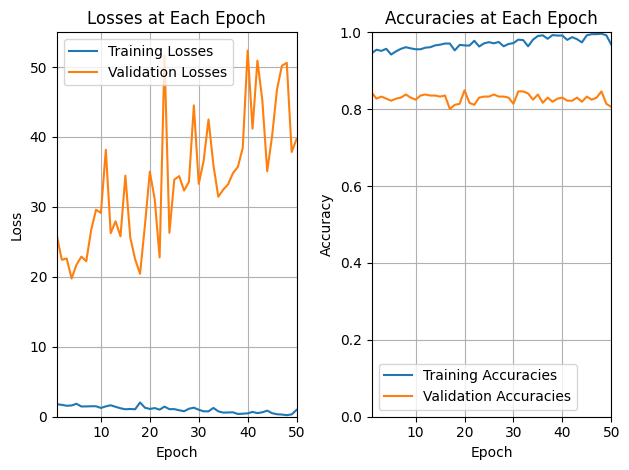

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_simple_cnn_LOW_RES.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_simple_cnn_LOW_RES.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_simple_cnn_LOW_RES.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_simple_cnn_LOW_RES.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

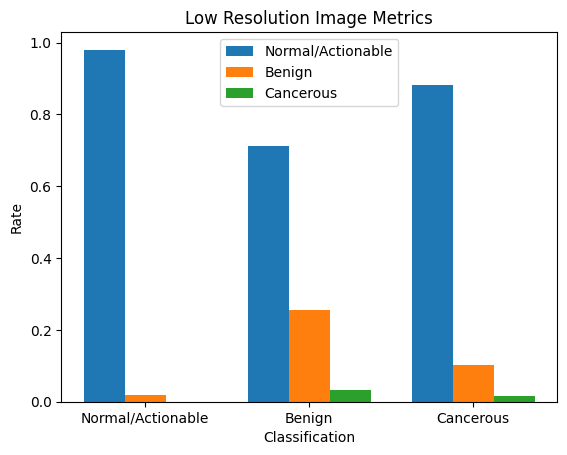

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_simple_cnn_LOW_RES[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_simple_cnn_LOW_RES[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_simple_cnn_LOW_RES[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Low Resolution Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 2, LOW_CONTRAST

In [ ]:
model_simple_cnn_LOW_CONTRAST = simple_cnn_model()
model_simple_cnn_LOW_CONTRAST = compile(model_simple_cnn_LOW_CONTRAST, class_weights_simple_cnn)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 3)                

In [ ]:
hist_simple_cnn_LOW_CONTRAST = fit(model_simple_cnn_LOW_CONTRAST,
                          training_array_LOW_CONTRAST,
                          training_labels_array,
                          validation_array_LOW_CONTRAST,
                          validation_labels_array)

Epoch 1/50
53/53 [==============================] - 2s 29ms/step - loss: 8.8281 - accuracy: 0.8238 - val_loss: 34.1238 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 23ms/step - loss: 4.9668 - accuracy: 0.8875 - val_loss: 25.5203 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 23ms/step - loss: 4.9202 - accuracy: 0.8875 - val_loss: 27.9630 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 23ms/step - loss: 4.5021 - accuracy: 0.8893 - val_loss: 22.8599 - val_accuracy: 0.8059
Epoch 5/50
53/53 [==============================] - 1s 23ms/step - loss: 4.7563 - accuracy: 0.8923 - val_loss: 26.7663 - val_accuracy: 0.8032
Epoch 6/50
53/53 [==============================] - 1s 23ms/step - loss: 4.0067 - accuracy: 0.8946 - val_loss: 20.5512 - val_accuracy: 0.8410
Epoch 7/50
53/53 [==============================] - 1s 23ms/step - loss: 4.0881 - accuracy: 0.9012 - val_loss: 22.0672 - val_accuracy: 0.8410
Epoch 

In [ ]:
data_simple_cnn_LOW_CONTRAST = metrics(model_simple_cnn_LOW_CONTRAST, test_array_LOW_CONTRAST, test_labels_array)
norm = np.sum(data_simple_cnn_LOW_CONTRAST, axis=1)
data_simple_cnn_LOW_CONTRAST = np.transpose(data_simple_cnn_LOW_CONTRAST / norm[:, np.newaxis])

1/1 [==============================] - 0s 21ms/step


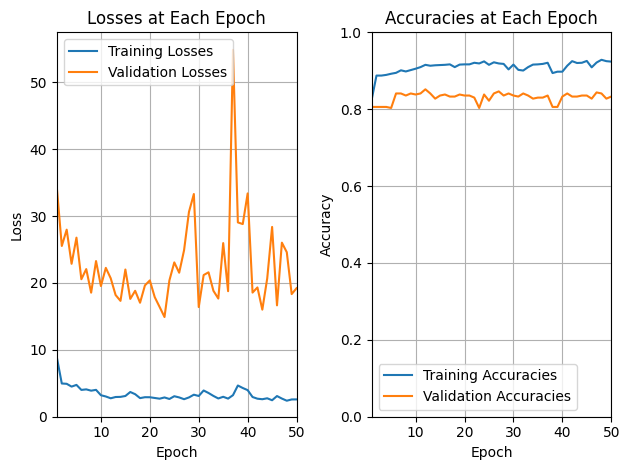

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_simple_cnn_LOW_CONTRAST.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_simple_cnn_LOW_CONTRAST.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_simple_cnn_LOW_CONTRAST.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_simple_cnn_LOW_CONTRAST.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

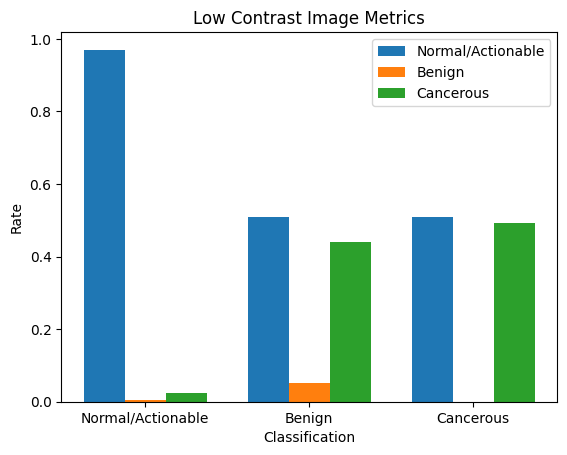

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_simple_cnn_LOW_CONTRAST[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_simple_cnn_LOW_CONTRAST[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_simple_cnn_LOW_CONTRAST[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Low Contrast Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 2, COMBINED

In [ ]:
model_simple_cnn_COMBINED = simple_cnn_model()
model_simple_cnn_COMBINED = compile(model_simple_cnn_COMBINED, class_weights_simple_cnn)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 3)                

In [ ]:
hist_simple_cnn_COMBINED = fit(model_simple_cnn_COMBINED,
                          training_array_COMBINED,
                          training_labels_array,
                          validation_array_COMBINED,
                          validation_labels_array)

Epoch 1/50
53/53 [==============================] - 3s 30ms/step - loss: 6.6517 - accuracy: 0.8875 - val_loss: 30.1805 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 24ms/step - loss: 4.9791 - accuracy: 0.8875 - val_loss: 28.9427 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 24ms/step - loss: 4.6485 - accuracy: 0.8887 - val_loss: 33.2642 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 23ms/step - loss: 4.4054 - accuracy: 0.8899 - val_loss: 20.6953 - val_accuracy: 0.8113
Epoch 5/50
53/53 [==============================] - 1s 24ms/step - loss: 4.1293 - accuracy: 0.8982 - val_loss: 17.7693 - val_accuracy: 0.8383
Epoch 6/50
53/53 [==============================] - 1s 23ms/step - loss: 4.7751 - accuracy: 0.8958 - val_loss: 26.9318 - val_accuracy: 0.8059
Epoch 7/50
53/53 [==============================] - 1s 23ms/step - loss: 4.4547 - accuracy: 0.8929 - val_loss: 24.8877 - val_accuracy: 0.8086
Epoch 

In [ ]:
data_simple_cnn_COMBINED = metrics(model_simple_cnn_COMBINED, test_array_COMBINED, test_labels_array)
norm = np.sum(data_simple_cnn_COMBINED, axis=1)
data_simple_cnn_COMBINED = np.transpose(data_simple_cnn_COMBINED / norm[:, np.newaxis])

1/1 [==============================] - 0s 20ms/step


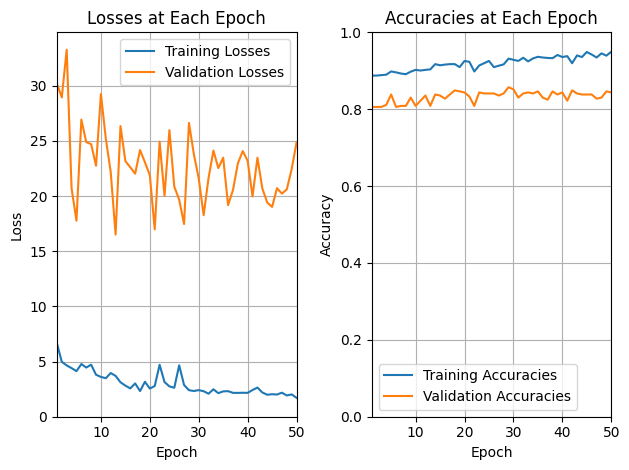

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_simple_cnn_COMBINED.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_simple_cnn_COMBINED.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_simple_cnn_COMBINED.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_simple_cnn_COMBINED.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

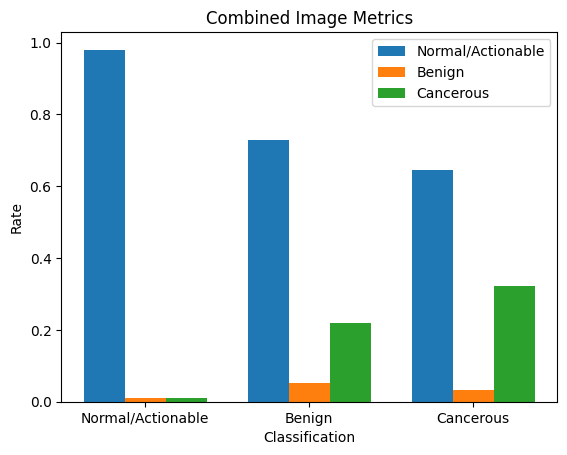

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_simple_cnn_COMBINED[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_simple_cnn_COMBINED[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_simple_cnn_COMBINED[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Combined Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 3, RAW

In [ ]:
# adapted from https://www.mdpi.com/2076-3417/12/11/5736
def alexnet_model():
    input_shape = (225, 225, 1)
    model = tf.keras.models.Sequential([
        # Input layer
        tf.keras.layers.InputLayer(input_shape=input_shape),

        # Convolution 1
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        # Convolution 2
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        # Convolution 3
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        # Convolution 4
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        # Convolution 5
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        # Flatten layer
        tf.keras.layers.Flatten(),

        # Fully connected layers
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

In [ ]:
class_weights_alexnet = {0: 1.0, 1: 10.0, 2: 200.0}

model_alexnet_RAW = alexnet_model()
model_alexnet_RAW = compile(model_alexnet_RAW, class_weights_alexnet)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 57, 57, 96)        11712     
                                                                 
 batch_normalization (Batch  (None, 57, 57, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 28, 28, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 256)       1024      
 chNormalization)                                                
                                                      

In [ ]:
hist_alexnet_RAW = fit(model_alexnet_RAW,
                       training_array_RAW,
                       training_labels_array,
                       validation_array_RAW,
                       validation_labels_array)

Epoch 1/50
53/53 [==============================] - 9s 47ms/step - loss: 7.7279 - accuracy: 0.8690 - val_loss: 26.5274 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 22ms/step - loss: 4.9270 - accuracy: 0.8685 - val_loss: 74.8211 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 22ms/step - loss: 4.9620 - accuracy: 0.8613 - val_loss: 77.5531 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 22ms/step - loss: 4.2606 - accuracy: 0.8821 - val_loss: 64.4702 - val_accuracy: 0.8059
Epoch 5/50
53/53 [==============================] - 1s 22ms/step - loss: 4.3830 - accuracy: 0.8821 - val_loss: 54.3060 - val_accuracy: 0.8059
Epoch 6/50
53/53 [==============================] - 1s 22ms/step - loss: 4.5428 - accuracy: 0.8851 - val_loss: 58.4041 - val_accuracy: 0.8032
Epoch 7/50
53/53 [==============================] - 1s 22ms/step - loss: 3.5603 - accuracy: 0.8869 - val_loss: 26.9851 - val_accuracy: 0.8194
Epoch 

In [ ]:
data_model_alexnet_RAW = metrics(model_alexnet_RAW, test_array_RAW, test_labels_array)
norm = np.sum(data_model_alexnet_RAW, axis=1)
data_model_alexnet_RAW = np.transpose(data_model_alexnet_RAW / norm[:, np.newaxis])

1/1 [==============================] - 0s 21ms/step


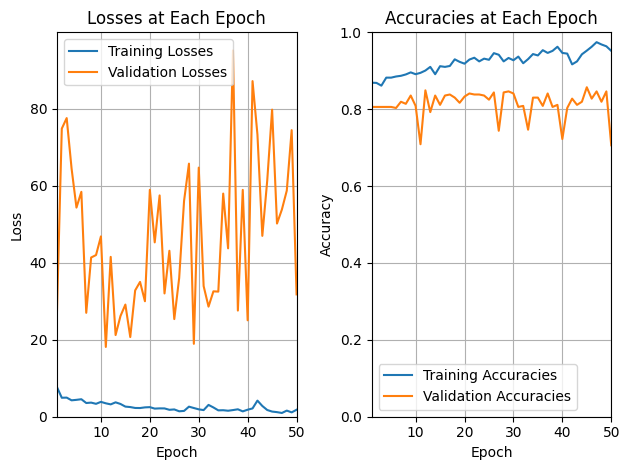

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_alexnet_RAW.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_alexnet_RAW.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_alexnet_RAW.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_alexnet_RAW.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

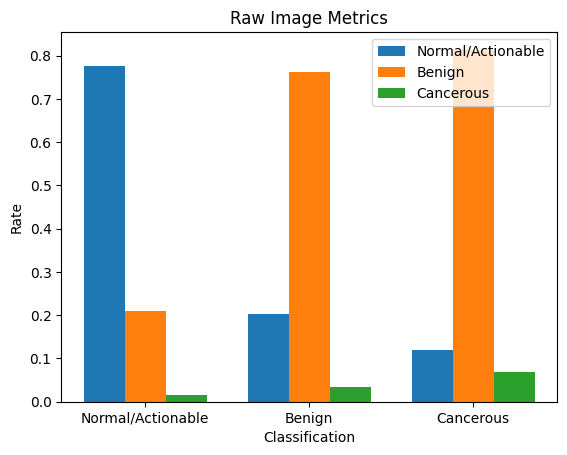

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_model_alexnet_RAW[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_model_alexnet_RAW[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_model_alexnet_RAW[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Raw Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 3, LOW_RES

In [ ]:
model_alexnet_LOW_RES = alexnet_model()
model_alexnet_LOW_RES = compile(model_alexnet_LOW_RES, class_weights_alexnet)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 57, 57, 96)        11712     
                                                                 
 batch_normalization_8 (Bat  (None, 57, 57, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 28, 28, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_9 (Bat  (None, 28, 28, 256)       1024      
 chNormalization)                                                
                                                     

In [ ]:
hist_alexnet_LOW_RES = fit(model_alexnet_LOW_RES,
                        training_array_LOW_RES,
                        training_labels_array,
                        validation_array_LOW_RES,
                        validation_labels_array)

Epoch 1/50
53/53 [==============================] - 5s 29ms/step - loss: 8.9125 - accuracy: 0.8661 - val_loss: 26.7659 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 22ms/step - loss: 6.0692 - accuracy: 0.8756 - val_loss: 134.9947 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 22ms/step - loss: 4.5896 - accuracy: 0.8804 - val_loss: 79.7603 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 22ms/step - loss: 5.1898 - accuracy: 0.8881 - val_loss: 50.0680 - val_accuracy: 0.8059
Epoch 5/50
53/53 [==============================] - 1s 22ms/step - loss: 4.0947 - accuracy: 0.8887 - val_loss: 77.9485 - val_accuracy: 0.8059
Epoch 6/50
53/53 [==============================] - 1s 22ms/step - loss: 3.7871 - accuracy: 0.8940 - val_loss: 30.9709 - val_accuracy: 0.8059
Epoch 7/50
53/53 [==============================] - 1s 22ms/step - loss: 3.3516 - accuracy: 0.8887 - val_loss: 43.9045 - val_accuracy: 0.8059
Epoch

In [ ]:
data_model_alexnet_LOW_RES = metrics(model_alexnet_LOW_RES, test_array_LOW_RES, test_labels_array)
norm = np.sum(data_model_alexnet_LOW_RES, axis=1)
data_model_alexnet_LOW_RES = np.transpose(data_model_alexnet_LOW_RES / norm[:, np.newaxis])

1/1 [==============================] - 0s 21ms/step


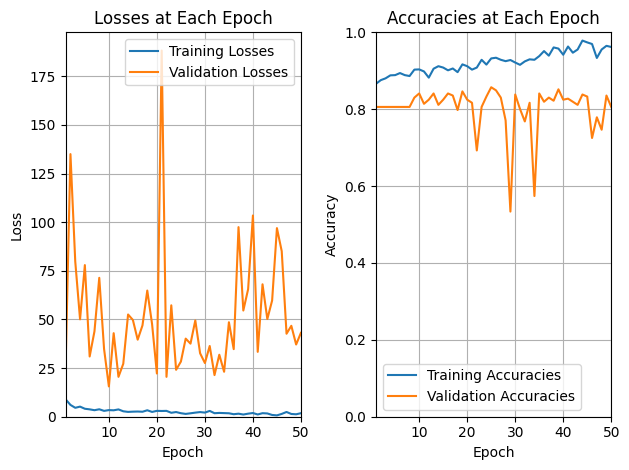

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_alexnet_LOW_RES.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_alexnet_LOW_RES.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_alexnet_LOW_RES.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_alexnet_LOW_RES.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

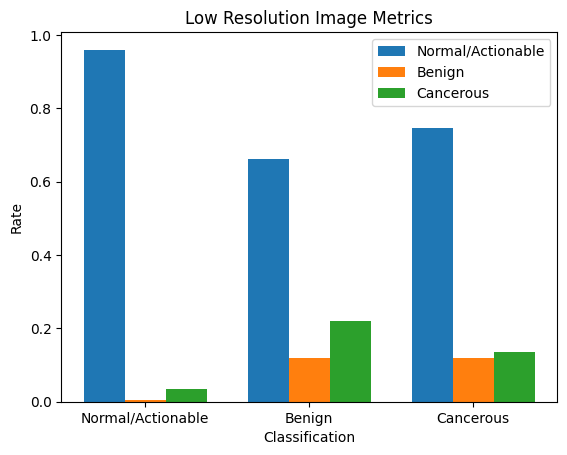

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_model_alexnet_LOW_RES[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_model_alexnet_LOW_RES[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_model_alexnet_LOW_RES[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Low Resolution Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 3, LOW_CONTRAST

In [ ]:
model_alexnet_LOW_CONTRAST = alexnet_model()
model_alexnet_LOW_CONTRAST = compile(model_alexnet_LOW_CONTRAST, class_weights_alexnet)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 57, 57, 96)        11712     
                                                                 
 batch_normalization_12 (Ba  (None, 57, 57, 96)        384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 28, 28, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_13 (Ba  (None, 28, 28, 256)       1024      
 tchNormalization)                                               
                                                     

In [ ]:
hist_alexnet_LOW_CONTRAST = fit(model_alexnet_LOW_CONTRAST,
                        training_array_LOW_CONTRAST,
                        training_labels_array,
                        validation_array_LOW_CONTRAST,
                        validation_labels_array)

Epoch 1/50
53/53 [==============================] - 5s 28ms/step - loss: 15.4691 - accuracy: 0.8673 - val_loss: 29.3555 - val_accuracy: 0.7978
Epoch 2/50
53/53 [==============================] - 1s 21ms/step - loss: 4.8266 - accuracy: 0.8905 - val_loss: 142.7399 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 21ms/step - loss: 4.7250 - accuracy: 0.8696 - val_loss: 86.4562 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 21ms/step - loss: 4.3907 - accuracy: 0.8792 - val_loss: 142.3748 - val_accuracy: 0.8059
Epoch 5/50
53/53 [==============================] - 1s 22ms/step - loss: 4.2245 - accuracy: 0.8917 - val_loss: 123.0135 - val_accuracy: 0.8059
Epoch 6/50
53/53 [==============================] - 1s 21ms/step - loss: 4.5421 - accuracy: 0.8792 - val_loss: 46.1194 - val_accuracy: 0.8086
Epoch 7/50
53/53 [==============================] - 1s 21ms/step - loss: 3.1572 - accuracy: 0.8982 - val_loss: 35.8561 - val_accuracy: 0.8248
Ep

In [ ]:
data_model_alexnet_LOW_CONTRAST = metrics(model_alexnet_LOW_CONTRAST, test_array_LOW_CONTRAST, test_labels_array)
norm = np.sum(data_model_alexnet_LOW_CONTRAST, axis=1)
data_model_alexnet_LOW_CONTRAST = np.transpose(data_model_alexnet_LOW_CONTRAST / norm[:, np.newaxis])

1/1 [==============================] - 0s 21ms/step


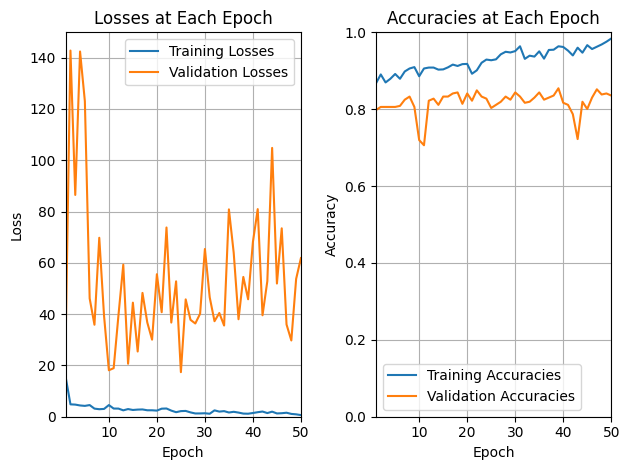

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_alexnet_LOW_CONTRAST.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_alexnet_LOW_CONTRAST.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_alexnet_LOW_CONTRAST.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_alexnet_LOW_CONTRAST.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

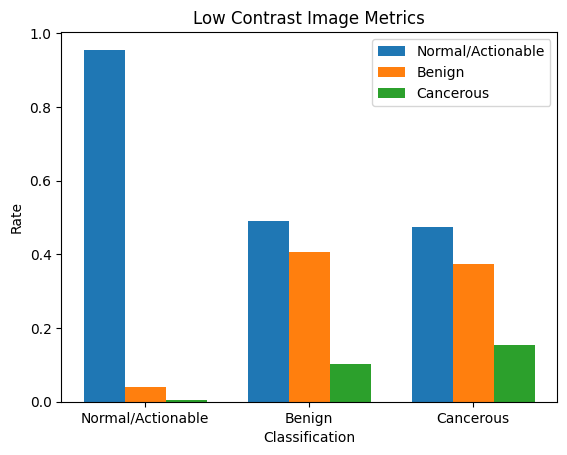

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_model_alexnet_LOW_CONTRAST[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_model_alexnet_LOW_CONTRAST[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_model_alexnet_LOW_CONTRAST[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Low Contrast Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

## Model 3, COMBINED

In [ ]:
model_alexnet_COMBINED = alexnet_model()
model_alexnet_COMBINED = compile(model_alexnet_COMBINED, class_weights_alexnet)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 57, 57, 96)        11712     
                                                                 
 batch_normalization_16 (Ba  (None, 57, 57, 96)        384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 28, 28, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_17 (Ba  (None, 28, 28, 256)       1024      
 tchNormalization)                                               
                                                     

In [ ]:
hist_alexnet_COMBINED = fit(model_alexnet_COMBINED,
                        training_array_COMBINED,
                        training_labels_array,
                        validation_array_COMBINED,
                        validation_labels_array)

Epoch 1/50
53/53 [==============================] - 5s 29ms/step - loss: 8.4024 - accuracy: 0.8762 - val_loss: 106.5588 - val_accuracy: 0.8059
Epoch 2/50
53/53 [==============================] - 1s 22ms/step - loss: 4.8586 - accuracy: 0.8750 - val_loss: 63.7796 - val_accuracy: 0.8059
Epoch 3/50
53/53 [==============================] - 1s 21ms/step - loss: 5.0435 - accuracy: 0.8869 - val_loss: 64.0951 - val_accuracy: 0.8059
Epoch 4/50
53/53 [==============================] - 1s 22ms/step - loss: 4.2765 - accuracy: 0.8839 - val_loss: 43.0818 - val_accuracy: 0.8059
Epoch 5/50
53/53 [==============================] - 1s 22ms/step - loss: 4.2581 - accuracy: 0.8887 - val_loss: 51.2816 - val_accuracy: 0.8032
Epoch 6/50
53/53 [==============================] - 1s 22ms/step - loss: 3.7606 - accuracy: 0.8911 - val_loss: 24.9704 - val_accuracy: 0.8329
Epoch 7/50
53/53 [==============================] - 1s 21ms/step - loss: 3.3619 - accuracy: 0.8917 - val_loss: 42.4740 - val_accuracy: 0.8275
Epoch

In [ ]:
data_model_alexnet_COMBINED = metrics(model_alexnet_COMBINED, test_array_COMBINED, test_labels_array)
norm = np.sum(data_model_alexnet_COMBINED, axis=1)
data_model_alexnet_COMBINED = np.transpose(data_model_alexnet_COMBINED / norm[:, np.newaxis])

1/1 [==============================] - 0s 23ms/step


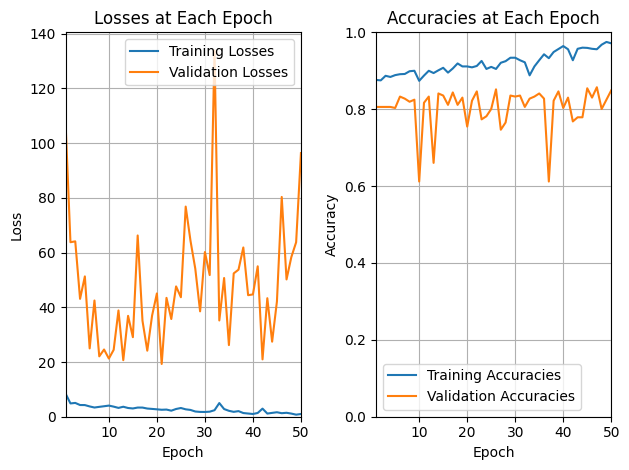

In [ ]:
# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1), hist_alexnet_COMBINED.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,51,1), hist_alexnet_COMBINED.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0)

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1), hist_alexnet_COMBINED.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,51,1), hist_alexnet_COMBINED.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(1, 50)
plt.ylim(0, 1)

# show plots
plt.tight_layout()
plt.show()

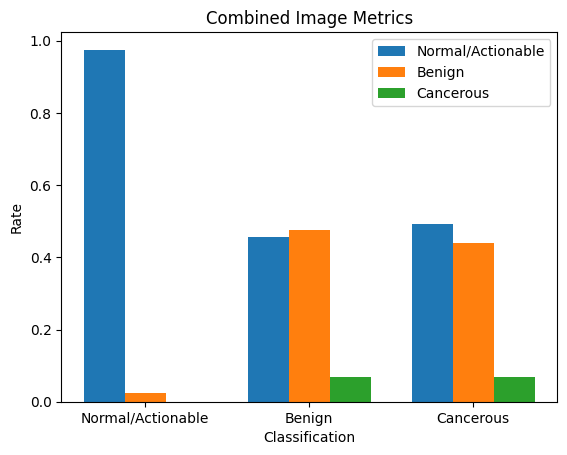

In [ ]:
# bar graphs
categories = ['Normal/Actionable', 'Benign', 'Cancerous']

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.array([0, 1, 2])

# Plotting
plt.bar(x - bar_width, data_model_alexnet_COMBINED[0], width=bar_width, label='Normal/Actionable')
plt.bar(x, data_model_alexnet_COMBINED[1], width=bar_width, label='Benign')
plt.bar(x + bar_width, data_model_alexnet_COMBINED[2], width=bar_width, label='Cancerous')

# Add labels, title, and legend
plt.xlabel('Classification')
plt.ylabel('Rate')
plt.title('Combined Image Metrics')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.show()

##Precision-Recall Curves

10/10 [==============================] - 0s 6ms/step


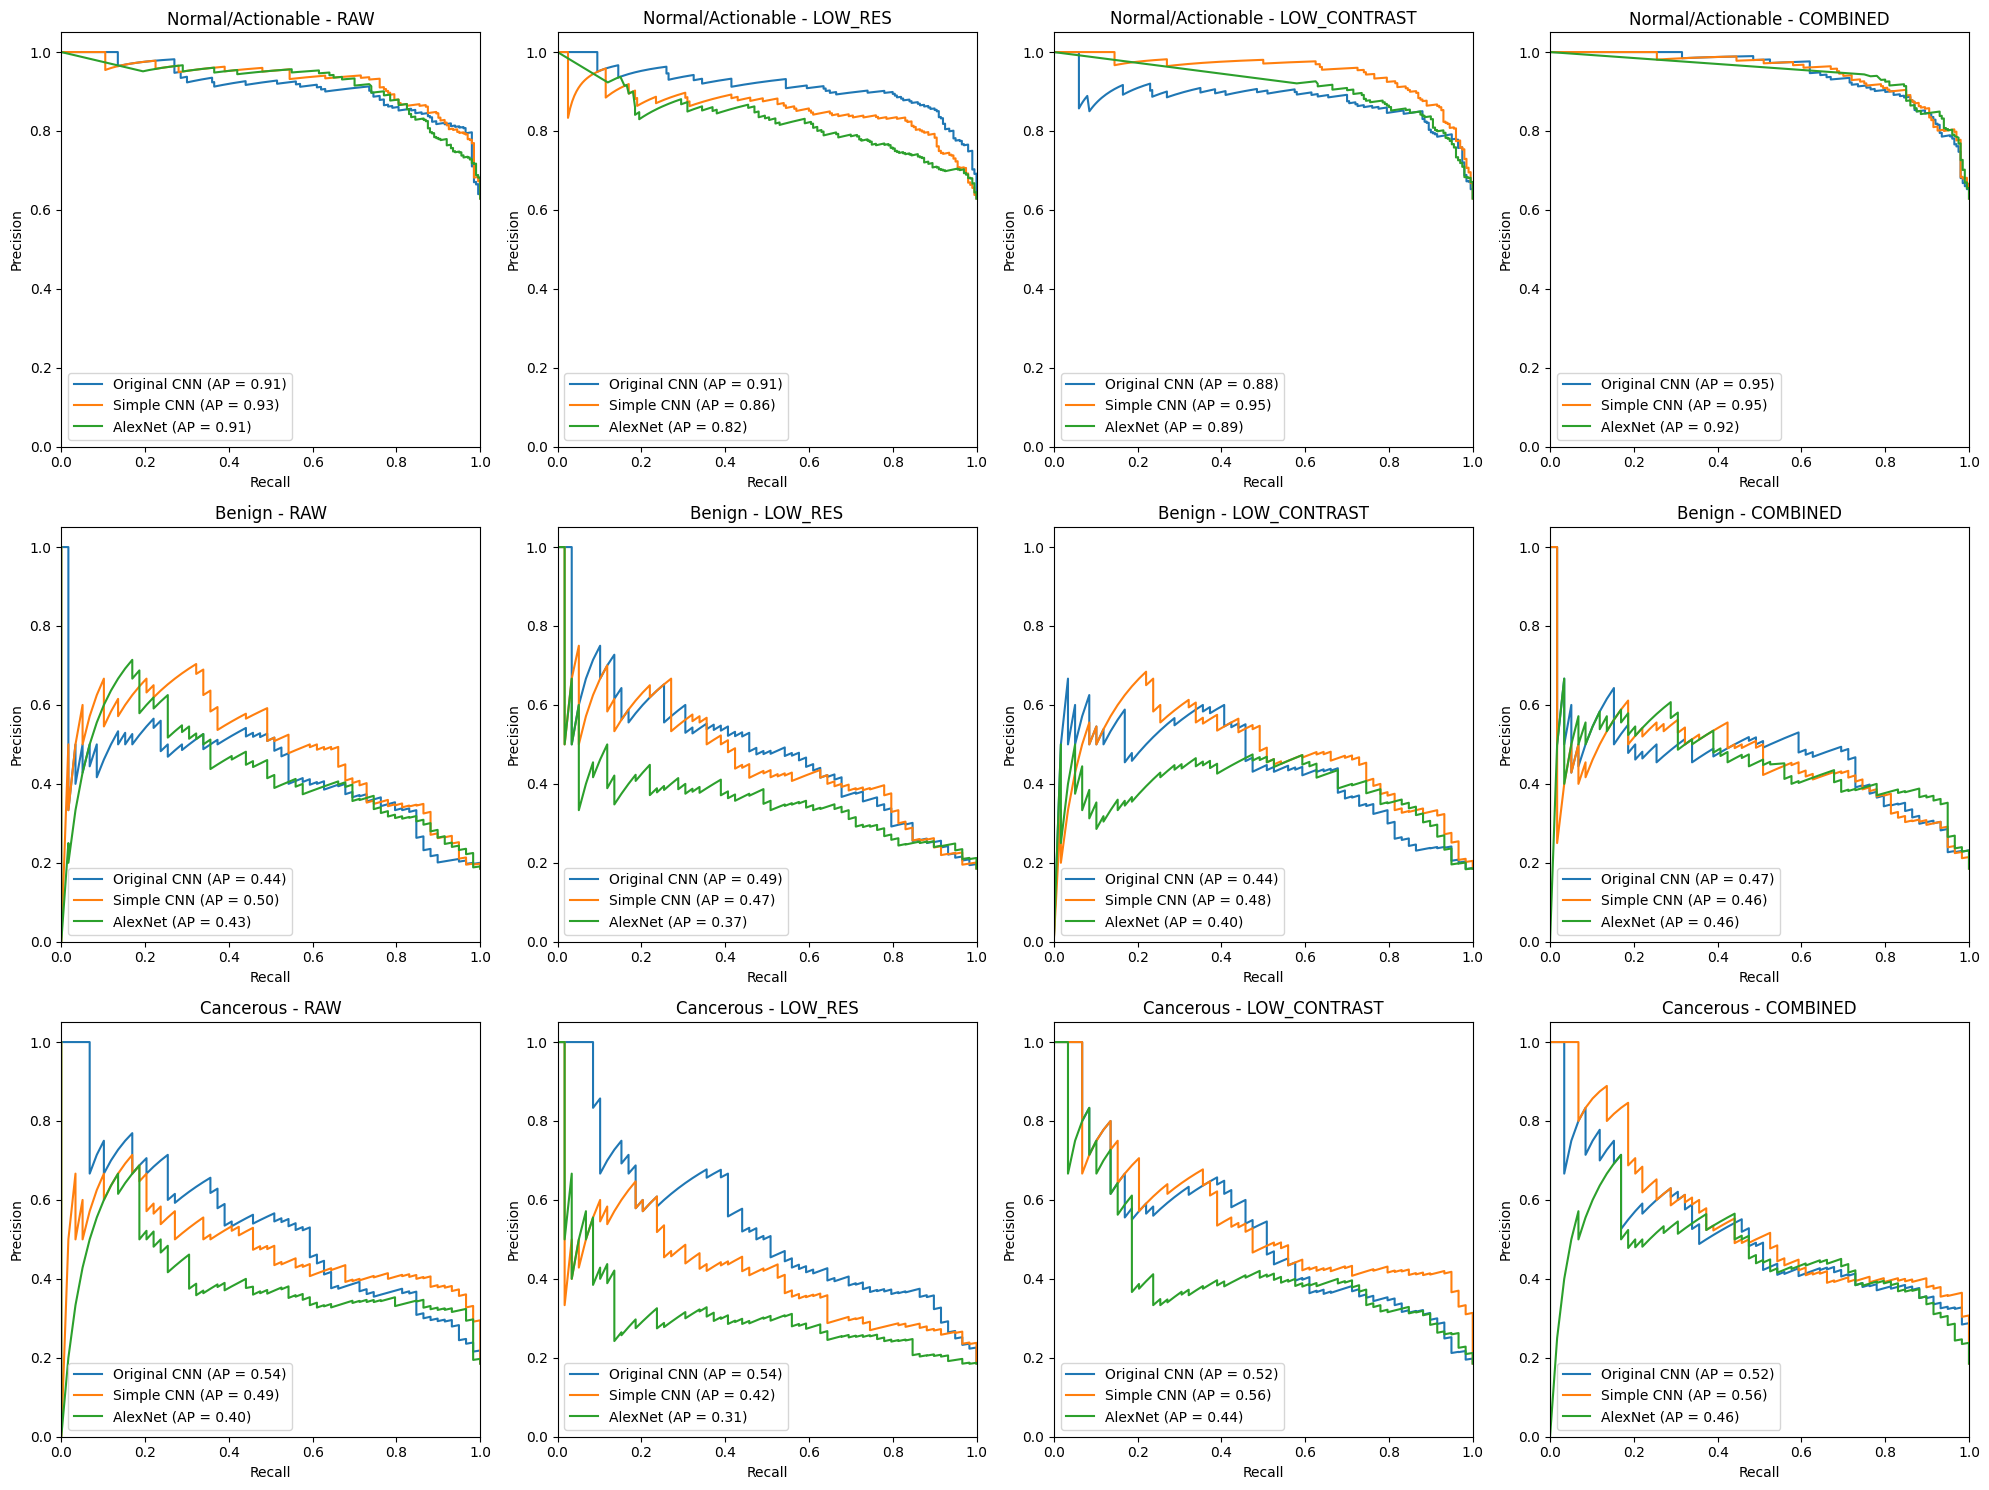

In [ ]:
def plot_pr_curves(y_true, y_pred_prob_list, model_names, test_case, ax):
    classes = ['Normal/Actionable', 'Benign', 'Cancerous']
    y_true_binary = label_binarize(y_true, classes=np.unique(y_true))

    for i, (model_name, y_pred_prob) in enumerate(zip(model_names, y_pred_prob_list)):
        precision, recall, _ = precision_recall_curve(y_true_binary[:, j], y_pred_prob[:, j])
        ap_score = average_precision_score(y_true_binary[:, j], y_pred_prob[:, j])
        ax.plot(recall, precision, label=f'{model_name} (AP = {ap_score:.2f})')
        ax.legend(loc='lower left')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{classes[j]} - {test_case}')

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

y_true_raw = test_labels_array
y_pred_prob_original_raw = model_original_RAW.predict(test_array_RAW.reshape(-1, 225, 225, 1))
y_pred_prob_simple_cnn_raw = model_simple_cnn_RAW.predict(test_array_RAW.reshape(-1, 225, 225, 1))
y_pred_prob_alexnet_raw = model_alexnet_RAW.predict(test_array_RAW.reshape(-1, 225, 225, 1))

y_true_low_res = test_labels_array
y_pred_prob_original_low_res = model_original_LOW_RES.predict(test_array_LOW_RES.reshape(-1, 225, 225, 1))
y_pred_prob_simple_cnn_low_res = model_simple_cnn_LOW_RES.predict(test_array_LOW_RES.reshape(-1, 225, 225, 1))
y_pred_prob_alexnet_low_res = model_alexnet_LOW_RES.predict(test_array_LOW_RES.reshape(-1, 225, 225, 1))

y_true_low_contrast = test_labels_array
y_pred_prob_original_low_contrast = model_original_LOW_CONTRAST.predict(test_array_LOW_CONTRAST.reshape(-1, 225, 225, 1))
y_pred_prob_simple_cnn_low_contrast = model_simple_cnn_LOW_CONTRAST.predict(test_array_LOW_CONTRAST.reshape(-1, 225, 225, 1))
y_pred_prob_alexnet_low_contrast = model_alexnet_LOW_CONTRAST.predict(test_array_LOW_CONTRAST.reshape(-1, 225, 225, 1))

y_true_combined = test_labels_array
y_pred_prob_original_combined = model_original_COMBINED.predict(test_array_COMBINED.reshape(-1, 225, 225, 1))
y_pred_prob_simple_cnn_combined = model_simple_cnn_COMBINED.predict(test_array_COMBINED.reshape(-1, 225, 225, 1))
y_pred_prob_alexnet_combined = model_alexnet_COMBINED.predict(test_array_COMBINED.reshape(-1, 225, 225, 1))

model_names = ['Original CNN', 'Simple CNN', 'AlexNet']

for j in range(3):
    plot_pr_curves(y_true_raw, [y_pred_prob_original_raw, y_pred_prob_simple_cnn_raw, y_pred_prob_alexnet_raw], model_names, 'RAW', axes[j, 0])
    plot_pr_curves(y_true_low_res, [y_pred_prob_original_low_res, y_pred_prob_simple_cnn_low_res, y_pred_prob_alexnet_low_res], model_names, 'LOW_RES', axes[j, 1])
    plot_pr_curves(y_true_low_contrast, [y_pred_prob_original_low_contrast, y_pred_prob_simple_cnn_low_contrast, y_pred_prob_alexnet_low_contrast], model_names, 'LOW_CONTRAST', axes[j, 2])
    plot_pr_curves(y_true_combined, [y_pred_prob_original_combined, y_pred_prob_simple_cnn_combined, y_pred_prob_alexnet_combined], model_names, 'COMBINED', axes[j, 3])

plt.tight_layout()
plt.show()

##Confusion Matrices

10/10 [==============================] - 0s 6ms/step


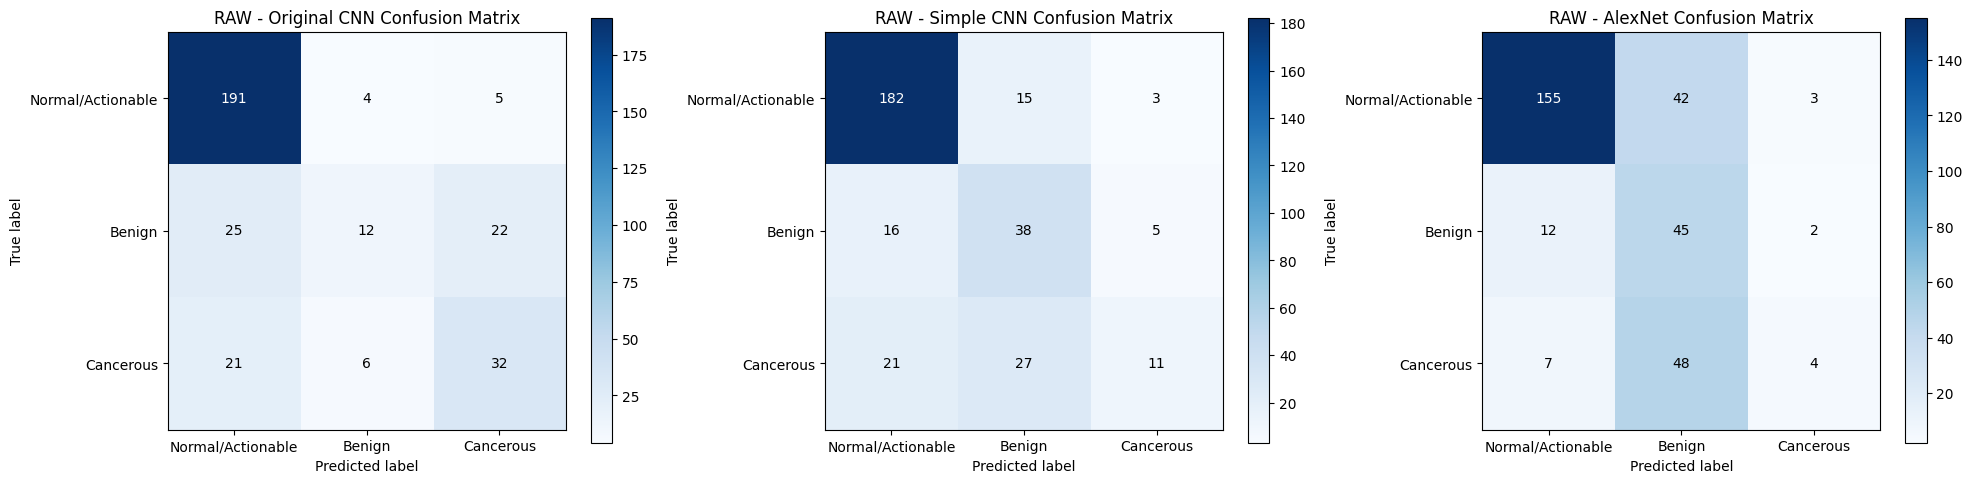

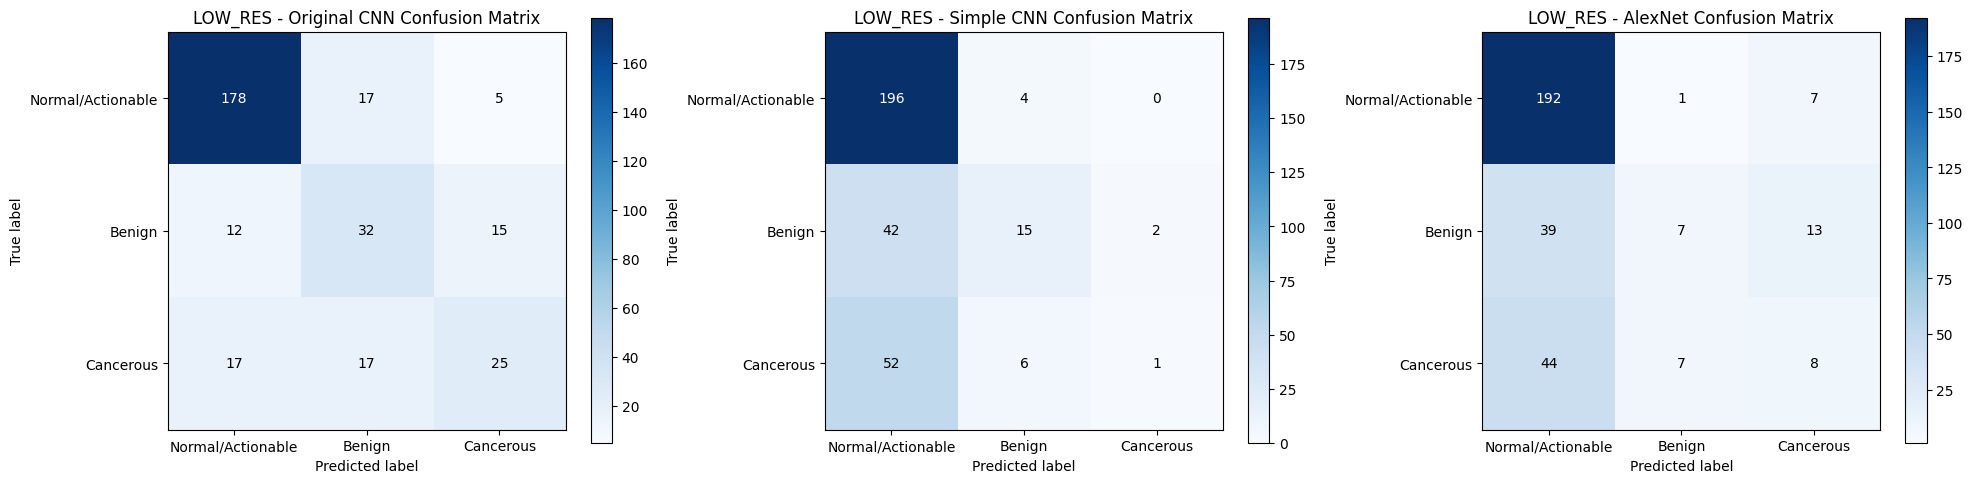

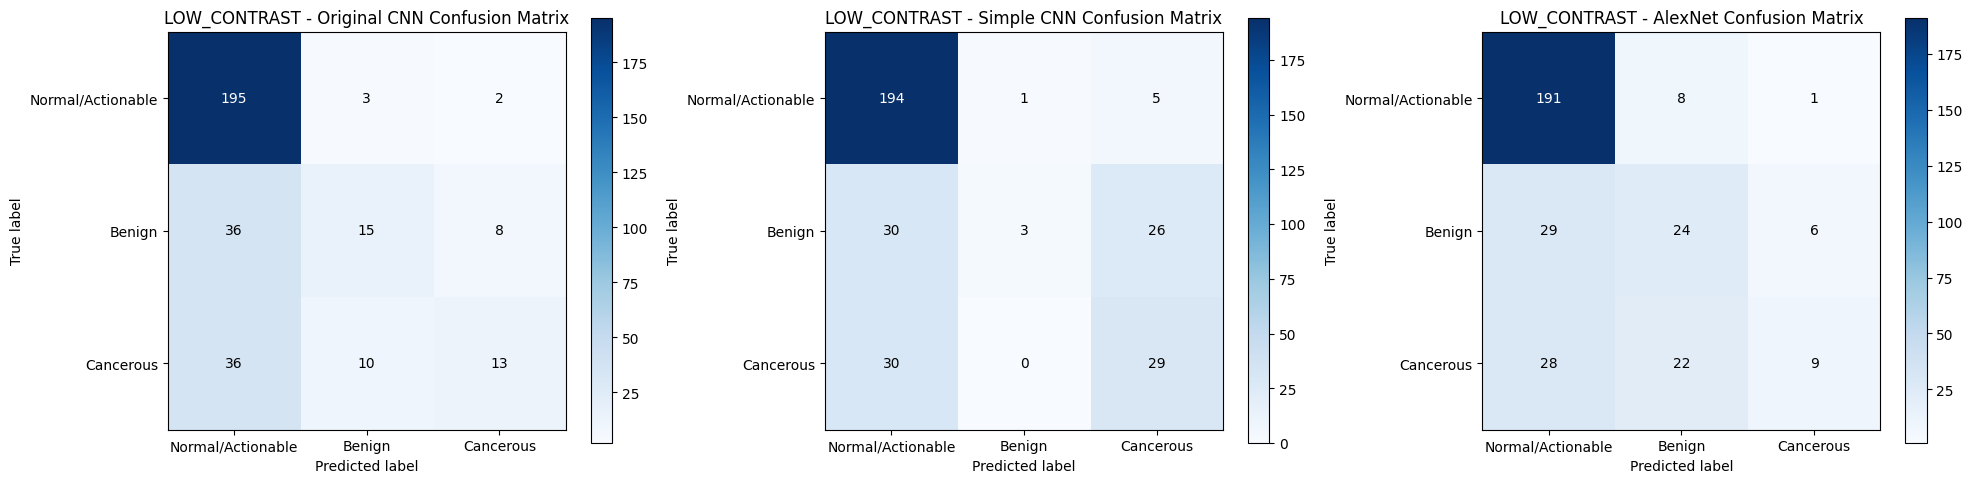

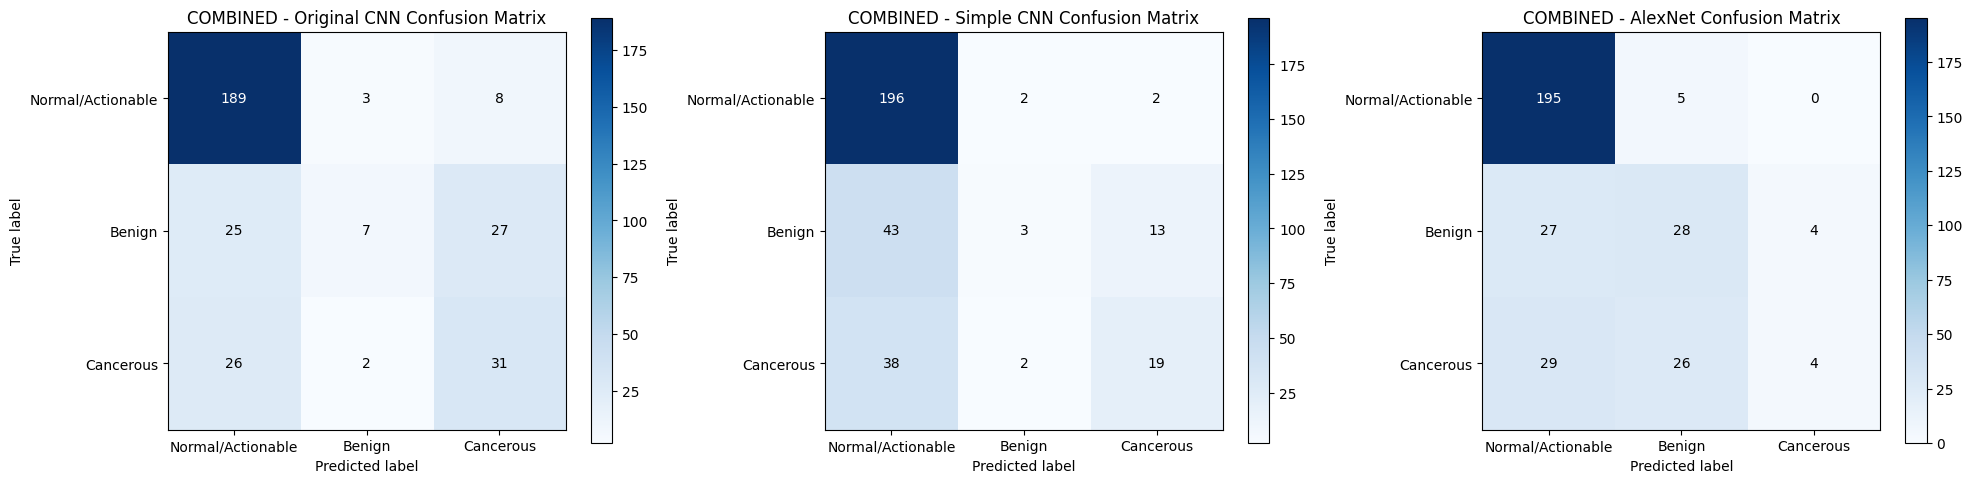

In [ ]:
def plot_confusion_matrix(y_true, y_pred_list, model_names, test_case):
    classes = ['Normal/Actionable', 'Benign', 'Cancerous']
    fig, ax = plt.subplots(1, len(model_names), figsize=(20, 5))

    for i, (model_name, y_pred) in enumerate(zip(model_names, y_pred_list)):
        cm = confusion_matrix(y_true, y_pred)

        im = ax[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax[i].figure.colorbar(im, ax=ax[i])

        ax[i].set(xticks=np.arange(cm.shape[1]),
                  yticks=np.arange(cm.shape[0]),
                  xticklabels=classes, yticklabels=classes,
                  title=f'{test_case} - {model_name} Confusion Matrix',
                  ylabel='True label',
                  xlabel='Predicted label')

        thresh = cm.max() / 2.
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                ax[i].text(k, j, format(cm[j, k], 'd'),
                           ha="center", va="center",
                           color="white" if cm[j, k] > thresh else "black")

    plt.tight_layout()
    plt.show()

# RAW test case
y_true_raw = test_labels_array
y_pred_original_raw = np.argmax(model_original_RAW.predict(test_array_RAW.reshape(-1, 225, 225, 1)), axis=1)
y_pred_simple_cnn_raw = np.argmax(model_simple_cnn_RAW.predict(test_array_RAW.reshape(-1, 225, 225, 1)), axis=1)
y_pred_alexnet_raw = np.argmax(model_alexnet_RAW.predict(test_array_RAW.reshape(-1, 225, 225, 1)), axis=1)

# LOW_RES test case
y_true_low_res = test_labels_array
y_pred_original_low_res = np.argmax(model_original_LOW_RES.predict(test_array_LOW_RES.reshape(-1, 225, 225, 1)), axis=1)
y_pred_simple_cnn_low_res = np.argmax(model_simple_cnn_LOW_RES.predict(test_array_LOW_RES.reshape(-1, 225, 225, 1)), axis=1)
y_pred_alexnet_low_res = np.argmax(model_alexnet_LOW_RES.predict(test_array_LOW_RES.reshape(-1, 225, 225, 1)), axis=1)

# LOW_CONTRAST test case
y_true_low_contrast = test_labels_array
y_pred_original_low_contrast = np.argmax(model_original_LOW_CONTRAST.predict(test_array_LOW_CONTRAST.reshape(-1, 225, 225, 1)), axis=1)
y_pred_simple_cnn_low_contrast = np.argmax(model_simple_cnn_LOW_CONTRAST.predict(test_array_LOW_CONTRAST.reshape(-1, 225, 225, 1)), axis=1)
y_pred_alexnet_low_contrast = np.argmax(model_alexnet_LOW_CONTRAST.predict(test_array_LOW_CONTRAST.reshape(-1, 225, 225, 1)), axis=1)

# COMBINED test case
y_true_combined = test_labels_array
y_pred_original_combined = np.argmax(model_original_COMBINED.predict(test_array_COMBINED.reshape(-1, 225, 225, 1)), axis=1)
y_pred_simple_cnn_combined = np.argmax(model_simple_cnn_COMBINED.predict(test_array_COMBINED.reshape(-1, 225, 225, 1)), axis=1)
y_pred_alexnet_combined = np.argmax(model_alexnet_COMBINED.predict(test_array_COMBINED.reshape(-1, 225, 225, 1)), axis=1)

model_names = ['Original CNN', 'Simple CNN', 'AlexNet']

plot_confusion_matrix(y_true_raw, [y_pred_original_raw, y_pred_simple_cnn_raw, y_pred_alexnet_raw], model_names, 'RAW')
plot_confusion_matrix(y_true_low_res, [y_pred_original_low_res, y_pred_simple_cnn_low_res, y_pred_alexnet_low_res], model_names, 'LOW_RES')
plot_confusion_matrix(y_true_low_contrast, [y_pred_original_low_contrast, y_pred_simple_cnn_low_contrast, y_pred_alexnet_low_contrast], model_names, 'LOW_CONTRAST')
plot_confusion_matrix(y_true_combined, [y_pred_original_combined, y_pred_simple_cnn_combined, y_pred_alexnet_combined], model_names, 'COMBINED')